Библиотеки которые можно использовать: librosa, NMFToolbox, Nimfa, Mido/Pretty_midi,MIDIUtil.

Из всех библиотек с реализацией NMF пока остановился на Nimfa, не пойдет с ней - буду пробовать работать с NMFToolbox. Перед тем как запускать код дальше надо установить Nimfa.

In [2]:
pip install nimfa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 41.8 MB/s eta 0:00:00


In [3]:
!grep -rl "np.mat" /usr/local/lib/python3.12/dist-packages/nimfa | xargs sed -i 's/np.mat/np.asmatrix/g'
!grep -rl "asmatrixrix" /usr/local/lib/python3.12/dist-packages/nimfa | xargs sed -i 's/asmatrixrix/asmatrix/g'
!grep -R "asmatrixrix" /usr/local/lib/python3.12/dist-packages/nimfa

**Читаем исходный файл**

In [4]:
from scipy.io import wavfile
import numpy as np
import librosa
import nimfa
gamma = 100
fft_bins = 2048
f_s, x = wavfile.read("/content/Prelude-in-E-Minor-Nr-4.wav")
print(f_s)        # sample rate
print(x.dtype)   # int16, int32, etc.
print(x.shape)   # (N,) mono or (N, channels)
#print(x[100000])
def init_nmf_template_pitch(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, R))
    for r in range(R):
        W[:, r] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W
def init_nmf_template_pitch_onset(K, pitch_set, freq_res, tol_pitch=0.05):
    """Initializes template matrix with onsets for a given set of pitches

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch_set (np.ndarray): Set of fundamental pitches
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x (2R) with R = len(pitch_set)
    """
    R = len(pitch_set)
    W = np.zeros((K, 2*R))
    for r in range(R):
        W[:, 2*r] = 0.1
        W[:, 2*r+1] = template_pitch(K, pitch_set[r], freq_res, tol_pitch=tol_pitch)
    return W
def template_pitch(K, pitch, freq_res, tol_pitch=0.05):
    """Defines spectral template for a given pitch

    Notebook: C8/C8S3_NMFSpecFac.ipynb

    Args:
        K (int): Number of frequency points
        pitch (float): Fundamental pitch
        freq_res (float): Frequency resolution
        tol_pitch (float): Relative frequency tolerance for the harmonics (Default value = 0.05)

    Returns:
        template (np.ndarray): Nonnegative template vector of size K
    """
    max_freq = K * freq_res
    pitch_freq = 2**((pitch - 69) / 12) * 440
    max_order = int(np.ceil(max_freq / ((1 - tol_pitch) * pitch_freq)))
    #print(max_freq,pitch_freq,max_order)
    template = np.zeros(K)
    for m in range(1, max_order + 1):
        min_idx = max(0, int((1 - tol_pitch) * m * pitch_freq / freq_res))
        max_idx = min(K-1, int((1 + tol_pitch) * m * pitch_freq / freq_res))
        template[min_idx:max_idx+1] = 1 / m
    return template
'''def spectrogram_thresholding(H,T=0.5):
  H_r = H.copy()
  for i in range(H.shape[0]):
    for j in range(H.shape[1]):
      if(H_r[i][j] < T):
        H_r[i][j] = 0
  return H_r'''
'''def pitch(p):
  return 2**((p-69)/12) * 440
def interval(freq, cents=20):
  return (freq * 2 ** (-cents/1200), freq * 2 ** (cents/1200))'''
if(x.dtype==np.int32):
  x = x / (2**31)
elif(x.dtype==np.int16):
  x = x / (2**15)
else:
  raise ValueError(f"Unsupported sample type: {x.dtype}")
#print("We've got here!")
spectrogram = np.abs(librosa.stft(x, n_fft=fft_bins,hop_length=1024))
#spectrogram = spectrogram_thresholding(spectrogram)
#spectrogram = np.zeros((((fft_bins//2+1),(x.shape[0]-2048)//1024+1)),dtype=np.complex128)
#spectrogram = librosa.stft(x, n_fft=fft_bins,hop_length=1024,out=spectrogram)
#print("We've got here1!")
spectrogram_compressed = np.log(1+gamma*spectrogram)
#print(x[100000])
#print(np.min(spectrogram_compressed),np.max(spectrogram_compressed))
#print(spectrogram_compressed.shape)
pitches = [x+21 for x in range(88)]
#pitches = [x for x in range(62,85)]
freq_res = f_s/(2 * (fft_bins//2+1))
#print("freq res=",freq_res)
def H(x):
  return (x+abs(x))/2
def summf(v1,v2):
  #v1 - spectral coefficients vector at moment n
  #v2 - spectral coefficients vector at moment (n+1)
  l = v1.shape[0]
  assert l == v2.shape[0]
  s = 0
  for i in range(l):
    s += (H(v2[i]-v1[i]))**2
  return s
def spec_diff(sp):
  res = []
  for i in range(sp.shape[1]-1):
    res.append(float(summf(sp[:,i],sp[:,i+1])))
  return res
H(5)
def eval_thrshld(d,n,M=100,abs_thrsh=0.1,lam=1.0):
  r = abs_thrsh
  n_s = n-M
  n_f = n+M
  if(n<M):
    n_s = M
  if(n+M>=len(d)):
    n_f = len(d)
  r += lam * np.median(d[n_s:n_f])
  return r
'''def peak_detect(data):
  res = np.zeros((len(data),))
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res[i] = 1
      lval = i
  return res'''
def peak_detect(data):
  #res = np.zeros((len(data),))
  res = []
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res.append(i)
      lval = i
  return res
data = spec_diff(spectrogram_compressed)
res = peak_detect(data)
def sparse_H(H,onsets):
  H_r = H.copy()
  for i in range(H_r.shape[1]):
    if(i in onsets or (i-1) in onsets or (i+1) in onsets):
      H_r[1::2,i] = 0
    else:
      H_r[0::2,i] = 0
  return H_r
print(res)
import matplotlib.pyplot as plt
W_temp = init_nmf_template_pitch(fft_bins//2+1,pitches,freq_res)
H_temp = np.random.rand(88, spectrogram_compressed.shape[1])
#H_temp = sparse_H(H_temp,res)
#nmf = nimfa.Nmf(spectrogram_compressed, seed='fixed', W=W_temp)
nmf = nimfa.Nmf(
    spectrogram_compressed,
    rank=88,
    seed='fixed',
    W=W_temp,
    H=H_temp,
    max_iter=200,
    beta=1, sparsity=(None, 0.2)
)
nmf_fit = nmf()
W_est = nmf_fit.basis()
H_est = nmf_fit.coef()

#H_new = H_est[1::2].copy()
H_new = H_est


/usr/local/lib/python3.12/dist-packages/nimfa/models/nmf.py:589: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if self.seed is not None and self.seed is not "fixed":
/usr/local/lib/python3.12/dist-packages/nimfa/methods/seeding/random.py:60: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if sn[0] is 'S' and sn[1:].isdigit():
/usr/local/lib/python3.12/dist-packages/nimfa/methods/factorization/sepnmf.py:276: SyntaxWarning: invalid escape sequence '\m'
  .. math:: \arg\min_{Y \ge 0} \| V - W H \|_F.


44100
int32
(5695232,)


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[85, 105, 125, 145, 165, 187, 207, 230, 253, 273, 297, 317, 340, 360, 381, 403, 426, 447, 467, 487, 507, 527, 551, 571, 596, 616, 637, 657, 681, 701, 721, 742, 762, 785, 807, 827, 848, 871, 891, 917, 939, 959, 981, 1001, 1022, 1042, 1063, 1085, 1105, 1131, 1151, 1171, 1191, 1211, 1240, 1262, 1290, 1311, 1331, 1351, 1373, 1393, 1413, 1438, 1465, 1487, 1509, 1531, 1551, 1571, 1591, 1611, 1636, 1658, 1680, 1702, 1722, 1742, 1762, 1788, 1808, 1835, 1858, 1881, 1909, 1931, 1951, 1975, 2005, 2033, 2053, 2076, 2096, 2116, 2136, 2156, 2179, 2203, 2226, 2246, 2268, 2289, 2309, 2333, 2353, 2374, 2395, 2418, 2438, 2462, 2482, 2502, 2522, 2542, 2563, 2583, 2603, 2623, 2644, 2664, 2685, 2705, 2731, 2753, 2774, 2796, 2817, 2837, 2858, 2879, 2900, 2923, 2945, 2966, 2986, 3006, 3027, 3048, 3069, 3089, 3114, 3134, 3157, 3177, 3199, 3226, 3246, 3266, 3286, 3307, 3331, 3352, 3372, 3392, 3412, 3432, 3452, 3472, 3492, 3514, 3535, 3556, 3578, 3600, 3621, 3642, 3662, 3687, 3711, 3733, 3756, 3776, 3797, 3821,

In [ ]:
print(len(res))

323


/tmp/ipython-input-2870127344.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo = float(tempo)          # or: tempo = tempo.item()


Estimated tempo: 114.84 BPM
beat_frames= [152, 173, 194, 215, 236, 257, 278, 299, 322, 344, 367, 389, 412, 434, 456, 478, 500, 527, 553, 575, 597, 619, 641, 663, 684, 705, 725, 745, 765, 787, 810, 832, 854, 876, 898, 920, 940, 962, 983, 1005, 1027, 1049, 1070, 1092, 1113, 1135, 1154, 1173, 1191, 1213, 1234, 1255, 1276, 1297, 1318, 1339, 1360, 1382, 1403, 1425, 1446, 1468, 1489, 1511, 1533, 1556, 1578, 1602, 1625, 1649, 1672, 1695, 1719, 1742, 1766, 1790, 1814, 1838, 1859, 1884, 1911, 1933, 1956, 1979, 2001, 2023, 2046, 2068, 2090, 2112, 2134, 2157, 2180, 2203, 2226, 2249, 2272, 2295, 2318, 2341, 2364, 2387, 2410, 2433, 2455, 2478, 2501, 2523, 2548, 2573, 2596, 2611, 2631, 2653, 2675, 2697, 2719, 2740, 2762, 2783, 2806, 2828, 2850, 2872, 2894, 2916, 2938, 2960, 2982, 3004, 3026, 3050, 3072, 3094, 3116, 3139, 3161, 3182, 3203, 3221, 3239, 3260, 3282, 3308, 3333, 3357, 3381, 3403, 3428, 3452, 3471, 3493, 3516, 3537, 3559, 3580, 3602, 3623]
Beat positions (sec.): [ 3.54104308  4.02866213  

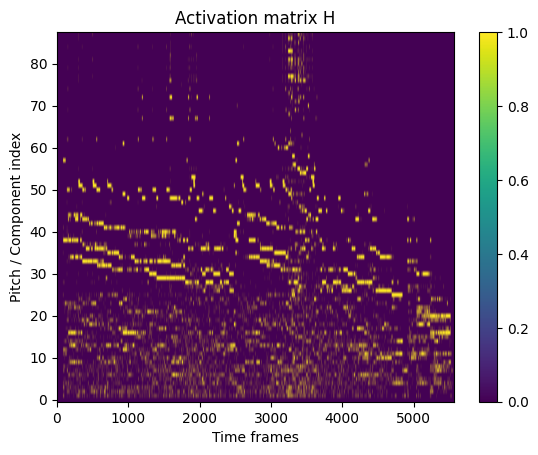

In [7]:
from scipy.ndimage import label
from scipy.ndimage import gaussian_filter1d
tempo, beats = librosa.beat.beat_track(y=x, sr=f_s)

tempo = float(tempo)          # or: tempo = tempo.item()

print(f"Estimated tempo: {tempo:.2f} BPM")

beat_times = librosa.frames_to_time(beats, sr=f_s)
beat_frames = list(map(int, beat_times * f_s / 1024))
print("beat_frames=",beat_frames)
print(f"Beat positions (sec.): {beat_times}")
def top_k_indices(v, k):
    v = np.asarray(v).ravel()      # ensure 1D ndarray
    return np.argpartition(v, -k)[-k:]
def note_tracking(H_new,onsets):
  H_n = H_new.copy()
  H_r = np.zeros(H_new.shape)
  #for t in onsets:
  for t in onsets:
    idx = top_k_indices(H_n[:,t],9)
    for i in idx:
      H_r[i,t] = 1
  return H_r
def note_tracking_m(H,th=1.4):
  mean = np.mean(H)
  std = np.std(H)
  thresh = mean + th * std
  H_copy = np.zeros(H.shape)
  for i in range(H.shape[1]):
    indicies = np.where(H[:,i] > thresh)
    H_copy[indicies,i] = 1
  return H_copy

def beat_sync_H(H, beat_frames, mode="mean"):
    Q, T = H.shape
    B = len(beat_frames) - 1
    H_beat = np.zeros((Q, B))

    for b in range(B):
        a, c = beat_frames[b], beat_frames[b+1]
        if mode == "mean":
            H_beat[:, b] = H[:, a:c].mean(axis=1)
        else:
            H_beat[:, b] = H[:, a:c].max(axis=1)

    return H_beat
#CONTINUE HERE
def generate_transcription(H_v,onsets):
  H_r = np.zeros(H_v.shape)
  mask = np.zeros(88)
  for i in range(H_v.shape[1]):
    if(i in onsets):
      H_r[:,i] = H_v[:,i]
      mask = H_v[:,i]
    else:
      H_r[:,i] = H_v[:,i] * mask
  return H_r

def enforce_min_duration(B, min_len=10):
    for q in range(B.shape[0]):
        labels, n = label(B[q])
        for i in range(1, n+1):
            if np.sum(labels == i) < min_len:
                B[q][labels == i] = 0
    return B



H_v = np.log(1+100*H_new)
H_w = H_v.copy()
H_w = note_tracking_m(H_w)
H_v = np.asarray(H_v)
H_v = H_v / (H_v.max(axis=1, keepdims=True) + 1e-8)
H_v = note_tracking(H_v,res)
#H_v = np.asarray(H_v)
#H_v = H_v / (H_v.max(axis=1, keepdims=True) + 1e-8)
#print(H_v.shape)
#H_v = np.asarray(H_v)
#H_v = note_tracking_paper_style(H_v)
H_v[0,:] = 0 #rough zero-ing A0 is the simplest way to approach NMF artefacts in low pitches
H_w[0,:] = 0 #rough zero-ing A0 is the simplest way to approach NMF artefacts in low pitches
#H_v = np.asarray(H_v)
#H_v = beat_sync_H(H_v,beat_frames)


#H_v = generate_transcription(H_v,res)
#H_v = enforce_min_duration(H_v)

import matplotlib.pyplot as plt
plt.figure()
#plt.imshow(H_v, aspect='auto', origin='lower')
plt.imshow(H_w, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

In [ ]:
print(H_v)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Попробуем готовый NMFD

In [ ]:
from scipy.io import wavfile
import numpy as np
import librosa
from convolutive_MM import convlutive_MM
import torch
from torchnmf.nmf import NMFD
gamma = 1
f_s, x = wavfile.read("/content/FChopinPreludeOp28n4.wav")
if(x.dtype==np.int32):
  x = x / (2**31)
elif(x.dtype==np.int16):
  x = x / (2**15)
else:
  raise ValueError(f"Unsupported sample type: {x.dtype}")
X = np.abs(librosa.stft(x, n_fft=2048,hop_length=1024))
print(f_s)        # sample rate
print(x.dtype)   # int16, int32, etc.
print(x.shape)   # (N,) mono or (N, channels)
print(x[100000])
def cnmf(V, n_components=8, n_lags=10, n_iter=100, eps=1e-9):
    """
    V: (F, T) non-negative matrix (e.g. magnitude spectrogram)
    W: (F, K, L)
    H: (K, T)
    """
    F, T = V.shape
    K = n_components
    L = n_lags

    # initialize
    W = np.random.rand(F, K, L)
    H = np.random.rand(K, T)

    for it in range(n_iter):
        print("Iteration number:",it)
        # reconstruct V_hat
        V_hat = np.zeros_like(V)
        for k in range(K):
            for l in range(L):
                V_hat[:, l:] += np.outer(W[:, k, l], H[k, :-l or None])

        # update H
        for k in range(K):
            num = np.zeros(T)
            den = np.zeros(T) + eps
            for l in range(L):
                Wkl = W[:, k, l][:, None]
                num[l:] += (Wkl * V[:, l:]).sum(axis=0)
                den[l:] += (Wkl * V_hat[:, l:]).sum(axis=0)
            H[k] *= num / den

        # update W
        for k in range(K):
            for l in range(L):
                num = (V[:, l:] * H[k, :-l or None]).sum(axis=1)
                den = (V_hat[:, l:] * H[k, :-l or None]).sum(axis=1) + eps
                W[:, k, l] *= num / den

        if it % 10 == 0:
            err = np.linalg.norm(V - V_hat)
            print(f"iter {it:3d} | error {err:.3f}")

    return W, H
#res = cnmf(X,88,10,100,eps=1e-9)
S = torch.from_numpy(X).float().unsqueeze(0)
model = NMFD(S.shape, rank=88, T=10)  # rank = components, T = time lags
model.fit(S, max_iter=200)
# Extract factors
W = model.W.detach().cpu().numpy()  # (F, rank, T)
H = model.H.detach().cpu().numpy()  # (batch, rank, time)

# Remove batch dimension from H
H = H[0]

ModuleNotFoundError: No module named 'convolutive_MM'

In [ ]:
pip install torchnmf

In [ ]:
print(H.shape)
print(H[:,100])

(88, 5418)
[2.83473209e-08 6.50976878e-03 1.41789596e-05 1.52520073e-07
 6.73773190e-11 6.32580509e-03 4.19024815e-07 1.45695822e-07
 5.12761474e-02 5.86620565e-08 2.48410529e-03 1.86016359e-06
 3.35856169e-11 2.82648742e-01 6.40907327e-10 4.86882832e-13
 1.54526517e-01 1.78778432e-02 8.55022892e-02 2.62964522e-06
 1.24121982e-06 3.14110337e-04 2.75774291e-05 2.64729764e-02
 1.51610147e-05 1.17561613e-04 4.98511456e-03 2.54663263e-07
 8.55225977e-03 9.62969295e-08 7.92492528e-07 5.81414402e-01
 1.42720955e-08 7.23814758e-11 1.23293276e-09 3.87781256e-08
 1.10994971e+00 1.21309212e-08 3.84029475e-09 1.08044292e-03
 5.38210334e-05 6.71427081e-10 7.98618771e-07 3.76486016e-04
 3.88029031e-04 3.47614923e-06 4.01852667e-01 3.48497309e-07
 5.86884730e-02 3.26614757e-03 5.65014835e-09 1.82239184e-08
 7.23177118e-09 3.41943360e-06 1.21501932e+01 1.63683857e-20
 1.53367546e-05 1.36501212e-02 1.72257292e-04 5.52130332e-05
 1.34814968e-06 4.82613547e-03 5.68299438e-04 7.87530690e-02
 1.91205490e-

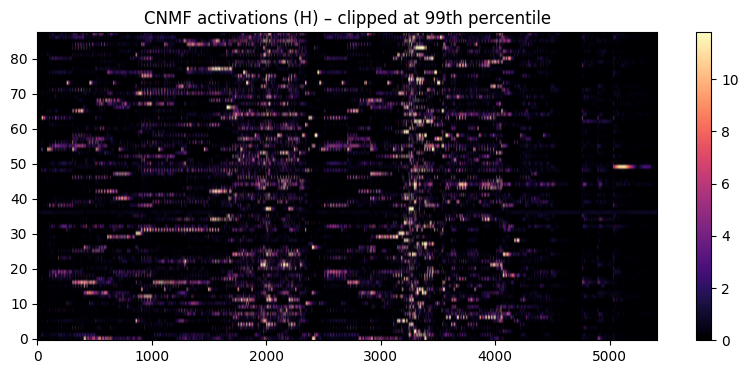

In [ ]:
import matplotlib.pyplot as plt

vmax = np.percentile(H, 99)

plt.figure(figsize=(10,4))
plt.imshow(
    H,
    aspect='auto',
    origin='lower',
    cmap='magma',
    vmin=0,
    vmax=vmax
)
plt.colorbar()
plt.title("CNMF activations (H) – clipped at 99th percentile")
plt.show()

# Пробуем CNMF (имплементация из libnmfd)

In [ ]:
pip install libnmfd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 98.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


# Обнаружение начал нот (Onsets detection)

Будем использовать подход, называемый Spectral Difference, вычисляя результат по формуле вот отсюда: https://www.iro.umontreal.ca/~pift6080/H09/documents/presentations/xavier_bello_tutorial.pdf

In [ ]:
def H(x):
  return (x+abs(x))/2
def summf(v1,v2):
  #v1 - spectral coefficients vector at moment n
  #v2 - spectral coefficients vector at moment (n+1)
  l = v1.shape[0]
  assert l == v2.shape[0]
  s = 0
  for i in range(l):
    s += (H(v2[i]-v1[i]))**2
  return s
def spec_diff(sp):
  res = []
  for i in range(sp.shape[1]-1):
    res.append(float(summf(sp[:,i],sp[:,i+1])))
  return res
H(5)
def eval_thrshld(d,n,M=100,abs_thrsh=0.1,lam=1.0):
  r = abs_thrsh
  n_s = n-M
  n_f = n+M
  if(n<M):
    n_s = M
  if(n+M>=len(d)):
    n_f = len(d)
  r += lam * np.median(d[n_s:n_f])
  return r
'''def peak_detect(data):
  res = np.zeros((len(data),))
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res[i] = 1
      lval = i
  return res'''
def peak_detect(data):
  #res = np.zeros((len(data),))
  res = []
  lval = 0
  for i in range(len(data)):
    if(data[i]>=eval_thrshld(data,i) and (i-lval)>=20):
      res.append(i)
      lval = i
  return res
data = spec_diff(spectrogram_compressed)
res = peak_detect(data)
def sparse_H(H,onsets):
  H_r = H.copy()
  for i in range(H_r.shape[1]):
    if(i in onsets or (i-1) in onsets or (i+1) in onsets):
      H[1::2,i] = 0
    else:
      H[0::2,i] = 0
  return H_r
print(res)
import matplotlib.pyplot as plt



[23, 45, 65, 86, 107, 127, 147, 169, 194, 215, 235, 255, 275, 295, 315, 339, 360, 380, 402]


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import numpy as np
def shift_right(x, k):
    if(k==0):
      return x
    y = np.zeros_like(x)
    y[k:] = x[:-k]
    return y
def note_template(pitch, alpha=0.5):
  r = np.zeros((88,))
  #first eight harmonics of some pitch
  l = [0,12,19,24,28,31,34,36]
  r[l]=1
  #print(pitch)
  r = shift_right(r,pitch)
  return r
def top_k_indices(v, k):
    return np.argsort(v)[-k:][::-1]
def rms(x):
    return np.sqrt(np.mean(np.square(x)))
def process_frame(s,k=3,en_thrsh=0.4):
    assert s.shape[0] == 88 and s.shape[1] == 1
    notes = []
    s_c = s.copy()
    s_c = np.asarray(s, dtype=float).squeeze()
    #print(type(s_c))
    #print("s_c=",s_c)
    s_pitches = top_k_indices(s_c,k)
    #print("s_pitches=",s_pitches)
    for l in s_pitches:
      #print(l)
      r = rms(np.dot(note_template(l),s_c))
      #print("r=",r)
      if(r>en_thrsh):
        notes.append(int(l))
    return notes
def note_tracking(mtr):
  r = np.zeros(mtr.shape)
  for i in range(mtr.shape[1]):
    ind = process_frame(mtr[:,i])
    for k in ind:
      r[k,i] = 1
  return r

In [ ]:
def note_tracking_paper_style(H, delta=0.1, win=10):
    Q, T = H.shape
    R = np.zeros_like(H, dtype=np.uint8)

    # 1. Per-pitch normalization (critical)
    '''keepdims=True'''
    Hn = H / (np.max(H, axis=1) + 1e-9)

    for q in range(Q):
        for t in range(T):

            # local mean (zero-padded)
            t0 = max(0, t - win)
            t1 = min(T, t + win + 1)
            local_mean = np.mean(Hn[q, t0:t1])

            # adaptive threshold
            thresh = local_mean + delta

            # onset condition (THIS is what you missed)
            if (
                Hn[q, t] > thresh and
                (t == 0 or Hn[q, t] > Hn[q, t - 1])
            ):
                R[q, t] = 1

    return R
H_n = np.log(1+H_est)
print(H_n.shape)
#H_n = note_tracking(H_n)
print(H_n.shape)
print(H_n[:,100].shape)

plt.figure()
#plt.imshow(np.log(1+200*H_est[1::2]), aspect='auto', origin='lower')
plt.imshow(note_tracking_paper_style(H_est), aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

(176, 7026)
(176, 7026)
(176, 1)


In [ ]:
def pitch_energy_compensation(H, gamma=0.7):
    """
    H: shape (88, T)
    """
    pitches = np.arange(88)
    weights = 2 ** (gamma * pitches / 12)
    weights = weights / weights.mean()  # normalize

    return H * weights[:, None]
H_n = np.log(1+H_est)
H_n = pitch_energy_compensation(H_n[1::2])
print(H_n.shape)
H_n = note_tracking(H_est)
print(H_n.shape)
print(H_n[:,100].shape)

plt.figure()
#plt.imshow(np.log(1+200*H_est[1::2]), aspect='auto', origin='lower')
plt.imshow(H_n, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

ValueError: shapes (88,7026) and (88,1) not aligned: 7026 (dim 1) != 88 (dim 0)

In [ ]:
print(H_s.shape)

(88, 418)


In [ ]:
print(note_template(0))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
v=[3,7,5,2,7,8,9,1,2,3,5,6,7,8,9,2,]
def top_k_indices(v, k):
    return np.argsort(v)[-k:][::-1]
print(top_k_indices(v, 9))

[14  6  5 13  1  4 12 11  2]


# Оценка результатов транскрибирования

In [ ]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 90.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.7 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.11-py3-none-any.whl size=5595886 sha256=843c15a8a767adb44b5adf0b8a2d13a42b1fc0a65a37cd6928f34227e8a33a18
  Stored in directory: /root/.cache/pip/wheels/f4/ad/93/a7042fe12668827574927ade9deec7f29aad2a1001b1501882
Successfully built pretty_midi


In [ ]:
import numpy as np
import pretty_midi

def midi_to_binary_matrix(
    midi_input,
    dt=0.02,                     # time quantum in seconds
    pitch_range=(21, 108),  # A0–C8 by default
    min_overlap=0.5         # fraction of frame that must be covered
):
    """
    Convert MIDI to binary (88 x T) note activation matrix using fixed time grid.

    A note is active in a frame if it overlaps the frame
    by at least min_overlap * dt.
    """

    if dt <= 0:
        raise ValueError("dt must be positive (seconds)")

    # Load MIDI
    if isinstance(midi_input, pretty_midi.PrettyMIDI):
        pm = midi_input
    else:
        pm = pretty_midi.PrettyMIDI(midi_input)

    # Time axis
    total_time = pm.get_end_time()
    T = int(np.ceil(total_time / dt))
    frame_times = np.arange(T) * dt

    n_pitches = pitch_range[1] - pitch_range[0] + 1
    B = np.zeros((n_pitches, T), dtype=np.uint8)

    # Process notes
    for instrument in pm.instruments:
        if instrument.is_drum:
            continue

        for note in instrument.notes:
            if not (pitch_range[0] <= note.pitch <= pitch_range[1]):
                continue

            p = note.pitch - pitch_range[0]

            start_frame = int(np.floor(note.start / dt))
            end_frame   = int(np.ceil(note.end   / dt))

            for t in range(start_frame, min(end_frame, T)):
                frame_start = t * dt
                frame_end   = frame_start + dt

                overlap = max(
                    0.0,
                    min(note.end, frame_end) - max(note.start, frame_start)
                )

                if overlap >= min_overlap * dt:
                    B[p, t] = 1

    return B, frame_times

0.023219954648526078
(88, 5562) (88, 5513)


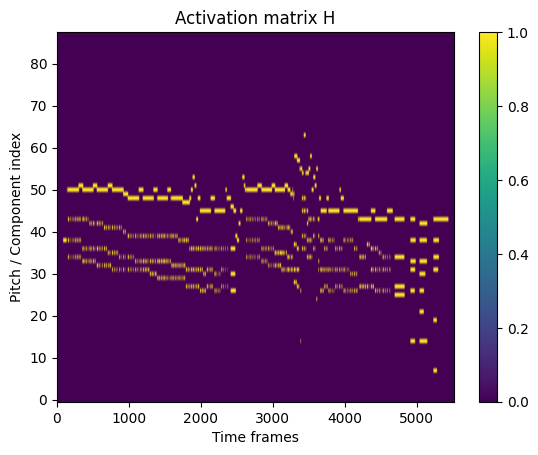

In [ ]:
# 20 ms frames (matches typical STFT hop ~512 @ 44.1kHz)
dt = 1024 / f_s
print(dt)
B, times = midi_to_binary_matrix(
    "Prelude-in-E-Minor-Nr-4.mid",
    dt=dt
)

print(H_v.shape, B.shape)   # (88, T)
import matplotlib.pyplot as plt
plt.figure()
#plt.imshow(H_v, aspect='auto', origin='lower')
plt.imshow(B, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Activation matrix H")
plt.xlabel("Time frames")
plt.ylabel("Pitch / Component index")
plt.show()

In [ ]:
def evaluate_results(H_et,H):
  #H_et - reference transcription of the piece
  #H - estimated transcription of the piece
  assert H_et.shape == H.shape
  P = 0
  R = 0
  F1 = 0
  TP = 0
  FP = 0
  FN = 0
  for i in range(H_et.shape[1]):
    TP += sum(1 for t, p in zip(H_et[:,i], H[:,i]) if t == 1 and p == 1)
    FP += sum(1 for t, p in zip(H_et[:,i], H[:,i]) if t == 0 and p == 1)
    FN += sum(1 for t, p in zip(H_et[:,i], H[:,i]) if t == 1 and p == 0)
  P = TP / (TP + FP)
  R = TP / (TP + FN)
  F1 = 2 * P * R / (P + R)
  return (P,R,F1)

In [ ]:
a = [0,1,1,1,0]
b = [1,1,1,0,0]
def top_k_indices(v, k):
    v = np.asarray(v).ravel()      # ensure 1D ndarray
    return np.argpartition(v, -k)[-k:]
print(top_k_indices(b,3))

[1 0 2]


In [ ]:
evaluate_results(H_v[:,:B.shape[1]],B)

(0.20825426944971537, 0.3734051601927984, 0.267384021926708)

In [ ]:
print(TP)

0
